In [1]:
import pandas as pd
df = pd.read_csv('movie-reviews-200.csv')
df.head()

,text,label
0,"I love this movie, it’s fantastic!",1
1,Absolutely wonderful acting and plot.,1
2,"I hated the ending, it was so bad.",0
3,Terrible movie. Waste of time.,0
4,"The story was okay, but acting was great.",1


In [2]:
texts = df['text'].values
target = df['label'].values

In [3]:
import spacy

nlp_model = spacy.load("en_core_web_sm")

def spacy_tokenizer(text):
    
    doc = nlp_model(text)
    tokens = [ token.lemma_.lower() for token in doc
        if (token.is_alpha and not token.like_num and not token.is_punct and not token.is_space and not token.is_stop)
    ]
    return tokens

In [4]:
tokens = [spacy_tokenizer(sentence) for sentence in texts]
all_words = sorted(set(word for item in tokens for word in item))
vocab_dir = {word: idx+2 for idx, word in enumerate(all_words)}
vocab_dir['<PAD>'] = 0
vocab_dir['<UNK>'] = 1

In [5]:
def text_to_sequence(token_bank, vocab_bank):
    return [[vocab_bank.get(word, vocab_bank['<PAD>']) for word in item] for item in token_bank]

In [6]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
text_sequence = text_to_sequence(tokens, vocab_dir)
padded_text = pad_sequences(text_sequence, padding='post') 

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    padded_text, target, test_size=0.2, random_state=42, stratify=target
)

## <b>Binary Class Classificaton</b>

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Embedding, Flatten
from tensorflow.keras import Sequential
from tqdm.keras import TqdmCallback
from tensorflow.keras.metrics import AUC

vocab_size = len(vocab_dir)
embedding_dim = 100
num_classes = len(set(target))

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=True),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', AUC()] 
)

In [10]:
history = model.fit(
    X_train, y_train,
    epochs=50,              # increase the epochs to train model very well
    verbose=0,              
    batch_size=32,
    validation_split=0.2,
    callbacks=[TqdmCallback(verbose=1)]
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [11]:
loss, acc, auc = model.evaluate(X_test, y_test, verbose=1)

print(f"Loss : {loss:.2f}")
print(f"Accuracy Score (ACC): {acc:.2f}")
print(f"AUC Score: {auc:.2f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9199 - auc: 0.9481 - loss: 0.4707
Loss : 0.51
Accuracy Score (ACC): 0.91
AUC Score: 0.94


In [12]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

predictions_prob = model.predict(X_test)
predictions = (predictions_prob > 0.5).astype(int)

print(f"Accuracy Score: {accuracy_score(y_test, predictions)}")
print(f"\nConfusion Matrix: \n{confusion_matrix(y_test, predictions)}")
print(f"\nClassification Report: \n{classification_report(y_test, predictions)}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Accuracy Score: 0.9111111111111111

Confusion Matrix: 
[[22  1]
 [ 3 19]]

Classification Report: 
              precision    recall  f1-score   support

           0       0.88      0.96      0.92        23
           1       0.95      0.86      0.90        22

    accuracy                           0.91        45
   macro avg       0.92      0.91      0.91        45
weighted avg       0.91      0.91      0.91        45



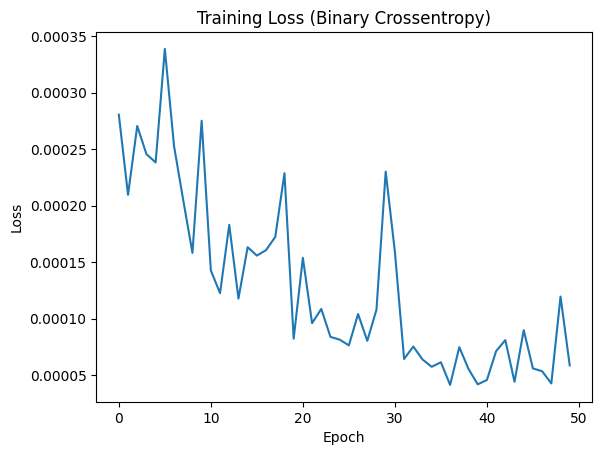

In [13]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.title("Training Loss (Binary Crossentropy)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [14]:
result_dict = {
    0: "Negative",
    1: "Positive"
}

In [24]:
sample_text = ["This movie was terrible and dull."]
sample_tokens = [spacy_tokenizer(sentence) for sentence in sample_text]
sample_seq = text_to_sequence(sample_tokens, vocab_dir)
sample_pad = pad_sequences(sample_seq, padding='post', maxlen=padded_text.shape[1])

pred = model.predict(sample_pad)
result_pred = (pred > 0.5).astype(int)
print(f"Predicted sentiment for give Sentence has : {result_dict[result_pred.tolist()[0][0]]} response")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Predicted sentiment for give Sentence has : Negative response


In [25]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 6, 100)         │        26,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        76,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 339,893 (1.30 MB)

 Trainable params: 113,297 (442.57 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 226,596 (885.14 KB)

## <b>Multi-Class Classification Model</b>

```python
vocab_size = len(vocab_dir)
embedding_dim = 100
num_classes = len(set(target))

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=True),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy', AUC()]
)

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    verbose=0,
    callbacks=[TqdmCallback(verbose=1)]
)

result_dict = {
    0: "Negative",
    1: "Neutral",
    2: "Positive"
}

sample_text = ["This movie was terrible and dull."]
sample_tokens = [spacy_tokenizer(sentence) for sentence in sample_text]
sample_seq = text_to_sequence(sample_tokens, vocab_dir)
sample_pad = pad_sequences(sample_seq, padding='post', maxlen=padded_text.shape[1])

pred = model.predict(sample_pad)
print(f"Predicted sentiment  for give Sentence has : {result_dict[pred.argmax(axis=1)[0]]} response")
```

## <b>LSTM Neural Network Model</b>

Perfect — you’ve already done a lot of the preprocessing work! You’ve tokenized your text, created a vocabulary, converted text to sequences, and padded them. Now, let’s complete the pipeline and **build and train an LSTM neural network** for binary classification (sentiment analysis).

Here’s the full example continuing from where you left off:

---

### ✅ Full LSTM Classification Example

```python
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Assuming you've already created:
# padded_text = ...
# target = df['labels'].values

# --- Split the data ---
X_train, X_test, y_train, y_test = train_test_split(padded_text, target, test_size=0.2, random_state=42)

# --- Define parameters ---
vocab_size = len(vocab_dir)      # total vocabulary size
embedding_dim = 64               # can tune this (32–128 common)
lstm_units = 64
max_len = padded_text.shape[1]   # sequence length

# --- Build the model ---
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    LSTM(lstm_units, return_sequences=False, dropout=0.2, recurrent_dropout=0.2),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary classification
])

# --- Compile the model ---
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# --- Train the model ---
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=2,
    verbose=1
)

# --- Evaluate ---
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {acc:.4f}")
```

---

### ✅ Notes:

* `Embedding` layer maps your integer-encoded words to dense vectors.
* `LSTM` captures sequential dependencies.
* The last `Dense(1, activation='sigmoid')` outputs a probability (0–1) for sentiment.
* You can adjust:

  * `embedding_dim` for richer representations
  * `lstm_units` for model capacity
  * `dropout` to prevent overfitting

---

### ✅ Example Prediction

After training, you can predict new reviews like this:

```python
sample_text = ["This movie was amazing!"]
sample_tokens = [spacy_tokenizer(sentence) for sentence in sample_text]
sample_seq = text_to_sequence(sample_tokens, vocab_dir)
sample_pad = pad_sequences(sample_seq, maxlen=max_len, padding='post')

pred = model.predict(sample_pad)
print("Positive" if pred[0][0] > 0.5 else "Negative", pred[0][0])
```

---

## <b>Multi-class LSTM Model</b>

### <b> Step 1: Setup </b>

We’ll assume you already have:

```python
texts = df['review'].values
target = df['labels'].values
```

…and the tokenization + padding steps you shared earlier:

```python
tokens = [spacy_tokenizer(sentence) for sentence in texts]
all_words = sorted(set(word for item in tokens for word in item))
vocab_dir = {word: idx+2 for idx, word in enumerate(all_words)}
vocab_dir['<PAD>'] = 0
vocab_dir['<UNK>'] = 1

def text_to_sequence(token_bank, vocab_bank):
    return [[vocab_bank.get(word, vocab_bank['<UNK>']) for word in item] for item in token_bank]

from tensorflow.keras.preprocessing.sequence import pad_sequences
text_sequence = text_to_sequence(tokens, vocab_dir)
padded_text = pad_sequences(text_sequence, padding='post')
```

---

### <b>Step 2: Train–Test Split</b>

```python
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    padded_text, target, test_size=0.2, random_state=42
)
```

---

### <b>Step 3: Define Model with LSTM</b>

```python
import tensorflow as tf

vocab_size = len(vocab_dir)       # total number of unique tokens
embedding_dim = 100               # can tune this
lstm_units = 64                   # can also tune this
num_classes = len(set(target))    # in your example: 3 (negative, neutral, positive)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        mask_zero=True  # ignore <PAD>
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units, dropout=0.3, recurrent_dropout=0.3)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.summary()
```

---

### <b>Step 4: Compile and Train</b>

```python
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)
```

---

### <b>Step 5: Evaluate</b>

```python
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.3f}")
```

---

### <b>Step 6: Example Prediction</b>

```python
sample_text = ["The film was outstanding and emotional."]
sample_tokens = [spacy_tokenizer(sentence) for sentence in sample_text]
sample_seq = text_to_sequence(sample_tokens, vocab_dir)
sample_pad = pad_sequences(sample_seq, padding='post', maxlen=padded_text.shape[1])

pred = model.predict(sample_pad)
print("Predicted sentiment label:", pred.argmax(axis=1)[0])
```

---

## <b>Pre-Trained Embedding</b>

Perfect! Using **pre-trained embeddings** like **GloVe** or **Word2Vec** often improves performance because the embeddings already capture semantic meaning from large corpora. Here’s how you can modify your LSTM model to use pre-trained embeddings.

---

### 1️⃣ Load Pre-trained Embeddings (GloVe Example)

```python
import numpy as np

embedding_index = {}
# Download GloVe (e.g., glove.6B.100d.txt) from https://nlp.stanford.edu/projects/glove/
with open("glove.6B.100d.txt", encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector

print(f"Found {len(embedding_index)} word vectors.")
```

---

### 2️⃣ Create an Embedding Matrix

```python
embedding_dim = 100  # Depends on the GloVe file you choose

vocab_size = len(vocab_dir)
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, idx in vocab_dir.items():
    if word in embedding_index:
        embedding_matrix[idx] = embedding_index[word]
    else:
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))  # Random init for unknown words
```

---

### 3️⃣ Build LSTM Model with Pre-trained Embeddings

```python
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=padded_text.shape[1],
              trainable=False),  # Set True if you want to fine-tune
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
model.summary()
```

---

### 4️⃣ Train the Model

```python
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=10,
                    batch_size=2)
```

---

### ✅ Notes:

* `trainable=False` keeps the GloVe embeddings fixed; set `True` to fine-tune.
* Pre-trained embeddings usually **improve accuracy**, especially with small datasets.
* You can try different GloVe sizes: `50d`, `100d`, `200d`, `300d`.

---

If you want, I can also show a **version using `trainable=True` with fine-tuning** which often boosts performance even more for your small dataset.

---